In [1]:
import scanpy as sc
import cell2location
from cell2location.models import RegressionModel
from sklearn.model_selection import train_test_split

2024-11-24 02:26:44.957752: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-24 02:26:44.965514: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-24 02:26:44.967838: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 02:26:45.385687: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# load reference scRNA-seq data

sc_ref = sc.read_h5ad('../data/adata_annotated.h5ad')
sc_ref

AnnData object with n_obs × n_vars = 3261 × 22425
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', 'leiden', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'cell_type_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [ ]:
# # calculate highly_variable_genes
# sc.pp.highly_variable_genes(sc_ref, n_top_genes=2000)
# sc_ref = sc_ref[:, sc_ref.var.highly_variable]


In [3]:
sc_ref

AnnData object with n_obs × n_vars = 3261 × 22425
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', 'leiden', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'cell_type_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [4]:
sc_ref.var['SYMBOL'] = sc_ref.var_names   # save var_names to 'SYMBOL'
sc_ref.var.set_index('gene_ids', drop = True, inplace = True)    # set ENSEMBL ID as index

# delete unnecessary raw slot
del sc_ref.raw

In [5]:
sc_ref.var

,feature_types,genome,n_cells,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection,mean,std,SYMBOL
gene_ids,,,,,,,,,,,,
ENSG00000238009,Gene Expression,GRCh38,14,False,0.005159,0.019838,-0.645383,0,False,0.003624,0.060757,AL627309.1
ENSG00000237491,Gene Expression,GRCh38,240,True,0.156626,1.463478,0.540453,2,False,0.066834,0.271388,AL669831.5
ENSG00000177757,Gene Expression,GRCh38,10,False,0.003980,0.150140,-0.001102,1,False,0.002824,0.058902,FAM87B
ENSG00000225880,Gene Expression,GRCh38,110,False,0.043453,0.712847,-0.744003,0,False,0.029729,0.174624,LINC00115
ENSG00000230368,Gene Expression,GRCh38,77,False,0.038254,0.841007,-0.458932,0,False,0.019073,0.142729,FAM41C
...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000276256,Gene Expression,GRCh38,45,False,0.026561,0.314034,-0.267720,1,False,0.009738,0.094090,AC011043.1
ENSG00000273748,Gene Expression,GRCh38,232,True,0.220938,1.632922,0.833285,2,False,0.070876,0.298880,AL592183.1
ENSG00000278817,Gene Expression,GRCh38,10,False,0.017512,1.109554,0.168256,1,False,0.003198,0.075275,AC007325.4


/home/jsw/jswenv/lib/python3.10/site-packages/cell2location/utils/filtering.py:30: RuntimeWarning: divide by zero encountered in log10
  cell_count_cutoff2 = np.log10(adata.shape[0] * cell_percentage_cutoff2)
/home/jsw/jswenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


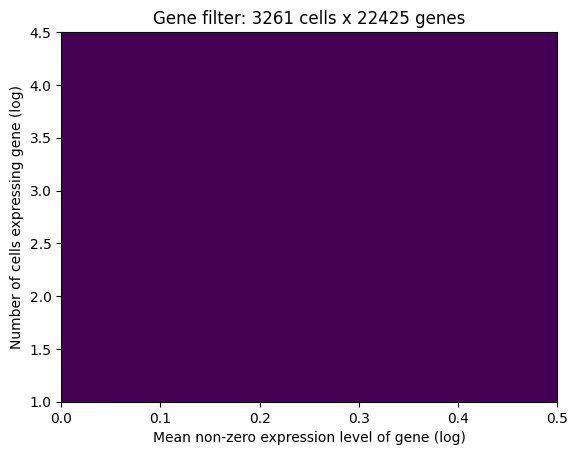

In [6]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(
    sc_ref,
    cell_count_cutoff=5,
    cell_percentage_cutoff2=0.00,
    nonz_mean_cutoff=1.12
)

In [ ]:
# filter the object
# sc_ref = sc_ref[:, selected].copy()

In [7]:
train_adata, val_adata = sc_ref[sc_ref.obs_names[:int(0.8 * len(sc_ref))]], sc_ref[sc_ref.obs_names[int(0.8 * len(sc_ref)):]]

In [8]:
sc_ref.obs

,sample,n_genes,n_genes_by_counts,total_counts,pct_counts_mito,pct_counts_ribo,leiden,cell_type
AAACGAAAGAAGCGGG-1,UKF313,225,225,305.0,0.983607,15.737705,1,CD4
AAACGAAGTTGTCAGT-1,UKF313,467,467,779.0,2.567394,6.546855,0,MG/Mp
AAAGAACGTACCTTCC-1,UKF313,316,316,479.0,3.131524,0.835073,12,DC
AAAGGGCAGGAACGCT-1,UKF313,232,232,308.0,4.870130,1.948052,0,MG/Mp
AAAGGTACAATCTGCA-1,UKF313,412,412,658.0,3.799392,6.079028,0,MG/Mp
...,...,...,...,...,...,...,...,...
TTTACTGGTTGGGTTT-1,UKF410,2532,2532,8099.0,5.259909,19.903690,3,CD8
TTTAGTCTCAGTCACA-1,UKF410,2811,2811,8684.0,2.671580,19.725933,3,CD8
TTTCACACAGCGTATT-1,UKF410,1225,1225,2449.0,0.530829,8.860760,13,Oligodendrocytes
TTTCAGTAGTGAGCCA-1,UKF410,781,781,1019.0,1.177625,3.434740,5,Oligodendrocytes


In [9]:
# Prepare anndata for the regression mocel (Negative binomial regression)
cell2location.models.RegressionModel.setup_anndata(
    adata = sc_ref,
    labels_key = 'cell_type',
    batch_key = 'sample',
    layer = 'counts',
    # categorical_covariate_keys=['Method']
)

In [10]:
# Create the regression model
mod = RegressionModel(sc_ref)

# View andata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.2.0.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'sample',
│   'labels_key': 'cell_type',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   5   │
│         n_cells          │ 3261  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  10   │
│          n_vars          │ 22425 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │   UKF313   │          0          │
│                     │   UKF315   │          1          │
│                     │   UKF334   │          2          │
│                     │   UKF357   │          3          │
│                     │   UKF410   │          4          │
└─────────────────────┴────────────┴─────────────────────┘

                       labels State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_type'] │    Malignant     │          0          │
│                        │      MG/Mp       │          1          │
│                        │     ILC/gdT      │          2          │
│                        │       CD4        │          3          │
│                        │ Oligodendrocytes │          4          │
│                        │       Treg       │          5          │
│                        │       CD8        │          6          │
│                        │        DC        │          7          │
│                        │       etc.       │          8          │
│                        │   Neutrophils    │          9          │
└────────────────────────┴──────────────────┴─────────────────────┘

In [11]:
mod.train(max_epochs=2000, train_size = 1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jsw/jswenv/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/jsw/jswenv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to impro

Training:   0%|          | 0/2000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2000` reached.


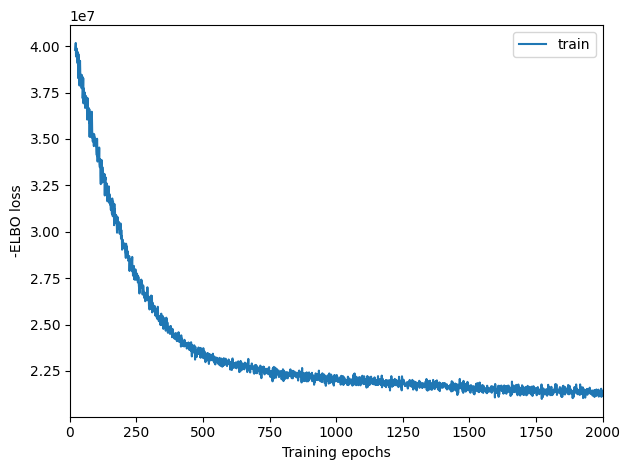

In [12]:
mod.plot_history(20)

In [13]:
# Export the estimated cell abundance (summary of the posterior distribution)
sc_ref = mod.export_posterior(
    sc_ref, sample_kwargs={'num_samples': 1000,}
)

Sampling local variables, batch:   0%|          | 0/26 [00:00<?, ?it/s]

Sampling global variables, sample:   0%|          | 0/999 [00:00<?, ?it/s]

In [14]:
# Save model
mod.save('../data/model', overwrite = True)

In [15]:
# Save anndata object with results
sc_ref.write('../data/adata_modelled.h5ad')
sc_ref

AnnData object with n_obs × n_vars = 3261 × 22425
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', 'leiden', 'cell_type', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std', 'SYMBOL', 'nonz_mean'
    uns: 'cell_type_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'umap', '_scvi_uuid', '_scvi_manager_uuid', 'mod'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs', 'means_per_cluster_mu_fg', 'stds_per_cluster_mu_fg', 'q05_per_cluster_mu_fg', 'q95_per_cluster_mu_fg'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

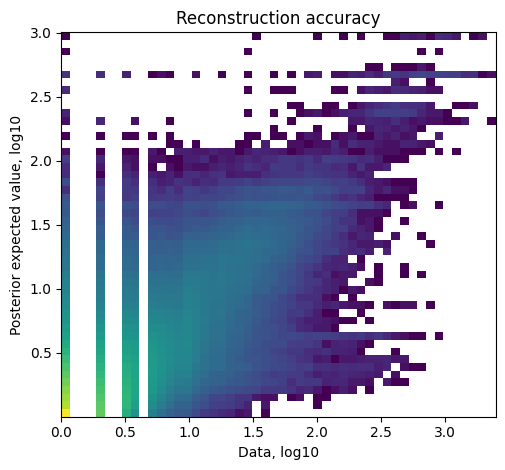

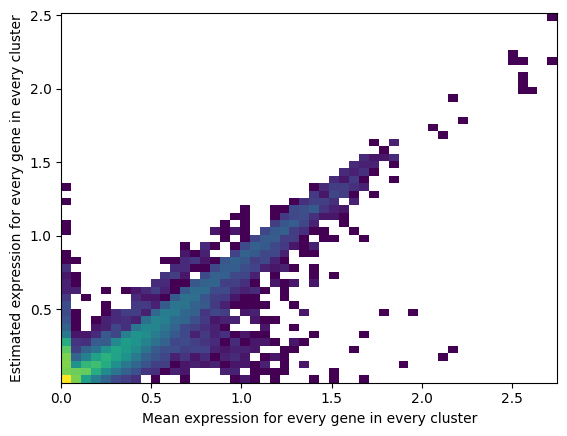

In [16]:
mod.plot_QC()

In [17]:
sc_ref

AnnData object with n_obs × n_vars = 3261 × 22425
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', 'leiden', 'cell_type', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std', 'SYMBOL', 'nonz_mean'
    uns: 'cell_type_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'umap', '_scvi_uuid', '_scvi_manager_uuid', 'mod'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs', 'means_per_cluster_mu_fg', 'stds_per_cluster_mu_fg', 'q05_per_cluster_mu_fg', 'q95_per_cluster_mu_fg'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [18]:
# Export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in sc_ref.varm.keys():
    inf_aver = sc_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                                       for i in sc_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = sc_ref.var[[f'means_per_cluster_mu_fg_{i}'
                           for i in sc_ref.uns['mod']['factor_names']]].copy() 
inf_aver.columns = sc_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,Malignant,MG/Mp,ILC/gdT,CD4,Oligodendrocytes
gene_ids,,,,,
ENSG00000238009,0.057637,0.003703,0.102649,0.005549,0.007247
ENSG00000237491,0.081443,0.052252,0.025860,0.023475,0.056431
ENSG00000177757,0.399859,0.012145,0.309249,0.042530,0.015617
ENSG00000225880,0.023534,0.022695,0.022366,0.019931,0.006090
ENSG00000230368,0.044308,0.014563,0.013256,0.007920,0.014330


In [19]:
inf_aver.to_csv('../data/inf_aver.csv')